In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

np.set_printoptions(suppress=True)
plt.rcParams["pdf.fonttype"] = 42

## Fig S3B

In [2]:
moseq_df = pd.read_csv('./moseq_df_filtered.csv')
stats_df = pd.read_csv('./moseq_stats_df_filtered.csv')

In [ ]:
# sorting the fingerprint
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from operator import pos
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

groupby_list=['treatment','mouse', 'treatment_day', 'uuid']
scalars=['velocity_2d_mm', 'distance_to_centroid_portion']

syll_summary = stats_df.pivot_table(index=groupby_list, values='usage', columns='syllable')
syll_summary.columns = pd.MultiIndex.from_arrays([['MoSeq'] * syll_summary.shape[1], syll_summary.columns])
min_syll_usg = np.quantile(syll_summary['MoSeq'].iloc[:, 4:], 0.01)
max_syll_usg = np.quantile(syll_summary['MoSeq'].iloc[:, 4:], 0.99)
min_v = np.quantile(moseq_df['velocity_2d_mm'], 0.01)
max_v = np.quantile(moseq_df['velocity_2d_mm'], 0.99)
min_centroid = 0
max_centroid = np.max(moseq_df['distance_to_centroid_portion'])
max_syll = 92
n_bins = max_syll +1
ranges = pd.DataFrame(np.array([[min_v, max_v], [min_centroid, max_centroid]]).T, index=['robust_min', 'robust_max'], columns=scalars)
range_idx = ['robust_min', 'robust_max']

def bin_scalars(data: pd.Series, n_bins=50):
    _range = ranges.loc[range_idx, data.name]
    bins = np.linspace(_range.iloc[0], _range.iloc[1], n_bins)

    binned_data = data.value_counts(normalize=True, sort=False, bins=bins)
    binned_data = binned_data.sort_index().reset_index(drop=True)
    binned_data.index.name = 'bin'
    return binned_data
def _apply_to_col(df, fn, **kwargs):
    return df.apply(fn, axis=0, **kwargs)

binned_scalars = moseq_df.groupby(groupby_list)[scalars].apply(_apply_to_col, fn=bin_scalars, n_bins=n_bins)
scalar_fingerprint = binned_scalars.pivot_table(index=groupby_list, columns='bin', values=binned_scalars.columns)
fingerprints = scalar_fingerprint.join(syll_summary, how='outer')
fingerprints.sort_index(level=[0,1,2], inplace=True)


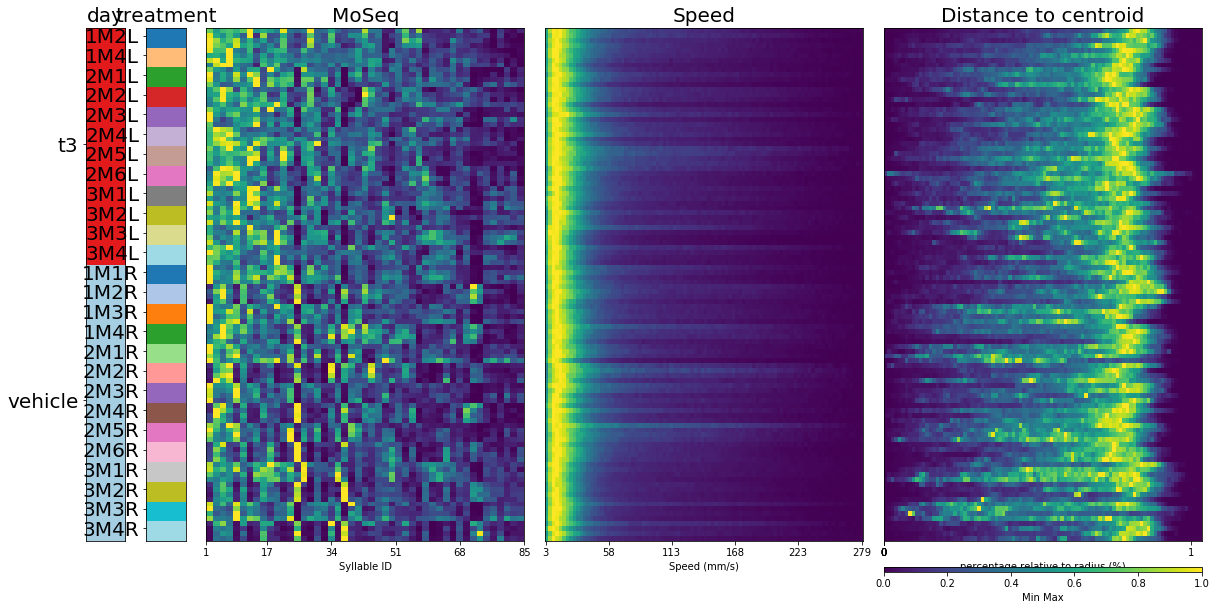

In [4]:

from matplotlib.colors import ListedColormap
from moseq2_viz.model.fingerprint_classifier import create_fingerprint_dataframe
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from operator import pos
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

def plotting_fingerprint(summary, range_dict, preprocessor=None, num_level =2, level_names = ['day','treatment'], vmin = None, vmax = None,
                         plot_columns=['MoSeq', 'velocity_2d_mm', 'distance_to_centroid_portion'],
                         col_names=[ ('MoSeq','Syllable ID'), ('Speed', 'Speed (mm/s)'), ('Distance to centroid', 'percentage relative to radius (%)'),]):
    # ensure number of groups is not over the number of available levels
    if num_level > len(summary.index.names):
        raise Exception('Too many levels to unpack. num_level should be less than', len(summary.index.names))

    name_map = dict(zip(plot_columns, col_names))
    
    levels = []
    level_plot = []
    level_ticks = []
    for i in range(num_level):
        level = summary.index.get_level_values(i)
        level_label = LabelEncoder().fit_transform(level)
        find_mid = (np.diff(np.r_[0,np.argwhere(np.diff(level_label)).ravel(),len(level_label)])/2).astype('int32')
        # store level value
        levels.append(level)
        level_plot.append(level_label)
        level_ticks.append(np.r_[0,np.argwhere(np.diff(level_label)).ravel()] + find_mid)
    
    # col_num = number of grouping/level + column in summary
    col_num = num_level + len(plot_columns)

    # https://matplotlib.org/stable/tutorials/intermediate/gridspec.html
    fig = plt.figure(1, figsize=(20, 10), facecolor='white')

    gs = GridSpec(2, col_num, wspace=0.1, hspace=0.1,
              width_ratios=[1]*num_level+[8]*(col_num-num_level), height_ratios = [10,0.1], figure=fig)

    # plot the level(s)
    for i in range(num_level):
        temp_ax = fig.add_subplot(gs[0,i])
        temp_ax.set_title(level_names[i], fontsize=20)
        if i == 0:
            cmap = ListedColormap([sns.color_palette("Paired")[5], sns.color_palette("Paired")[0]])
            temp_ax.imshow(level_plot[i][:,np.newaxis], aspect = 'auto', cmap = cmap)
        else:
            
            temp_ax.imshow(level_plot[i][:,np.newaxis], aspect = 'auto', cmap = 'tab20')
        plt.yticks(level_ticks[i], levels[i][level_ticks[i]], fontsize=20)
        
        temp_ax.get_xaxis().set_ticks([])
    
    # compile data to plot while recording vmin and vmax in the data
    plot_dict = {}
    # initialize vmin and vmax
    temp_vmin = np.Inf
    temp_vmax = -np.Inf
    
    for col in plot_columns:
        data = summary[col].to_numpy()
        # process data with preprocessor
        if preprocessor is not None:
            data = preprocessor.fit_transform(data.T).T

        if np.min(data) < temp_vmin:
            temp_vmin = np.min(data)
        if np.max(data) > temp_vmax:
            temp_vmax = np.max(data)

        plot_dict[col] = data
    
    if vmin is None:
        vmin = temp_vmin
    if vmax is None:
        vmax = temp_vmax

    # plot the data
    for i, col in enumerate(plot_columns):
        name = name_map[col]
        temp_ax = fig.add_subplot(gs[0, i + num_level])
        temp_ax.set_title(name[0], fontsize=20)
        data = plot_dict[col]
        
        # top to bottom is 0-20 for y axis
        if col == 'MoSeq':
            extent = [summary[col].columns[0], summary[col].columns[-1], len(summary) - 1, 0]
        else:
            extent = [range_dict[col].iloc[0], range_dict[col].iloc[1], len(summary) - 1, 0]

        pc = temp_ax.imshow(data, aspect='auto', interpolation='none', vmin=vmin, vmax=vmax, extent=extent)
        temp_ax.set_xlabel(name[1], fontsize=10)
        temp_ax.set_xticks(np.linspace(np.ceil(extent[0]), np.floor(extent[1]), 6).astype(int))
        # https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
        temp_ax.set_yticks([])
        temp_ax.axis = 'tight'
    
    # plot colorbar
    cb = fig.add_subplot(gs[1,-1])
    plt.colorbar(pc, cax=cb, orientation='horizontal')

    # specify labels for feature scaling
    if preprocessor:
        cb.set_xlabel('Min Max')
    else:
        cb.set_xlabel('Percentage Usage')
plotting_fingerprint(fingerprints, ranges.loc[range_idx], preprocessor=MinMaxScaler())

## Fig S3C

In [5]:
mean_df = pd.read_csv('./moseq_mean_df.csv')
dist_df = pd.read_csv('./moseq_dist_df.csv')

/Users/sherry/miniconda3/envs/moseq2-dev/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_1 vs. vehicle_1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.773e-01 U_stat=7.800e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_4 vs. vehicle_4: Mann-Whitney-Wilcoxon test two-sided, P_val:8.571e-01 U_stat=8.000e+01


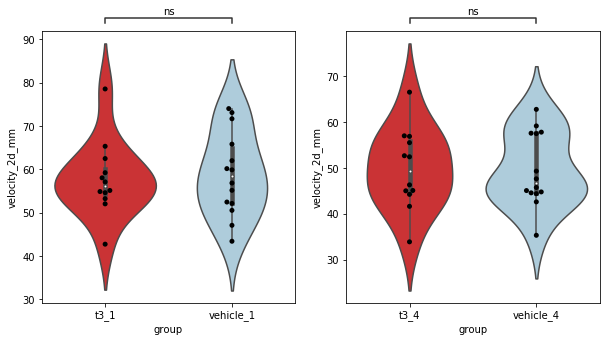

In [6]:
from statannotations.Annotator import Annotator
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()

days= ['_1', '_4']
for i in range(len(days)):
    plot_df = mean_df[mean_df.group.str.contains(days[i])].copy()
    t3_array = plot_df[plot_df.group.str.contains('t3')]['velocity_2d_mm'].values
    vehicle_array = plot_df[plot_df.group.str.contains('vehicle')]['velocity_2d_mm'].values
    sns.violinplot(data=plot_df, x = 'group', y = 'velocity_2d_mm', order = sorted(plot_df.group.unique()), ax = axs[i], palette=[sns.color_palette("Paired")[5], sns.color_palette("Paired")[0]])
    sns.swarmplot(data=plot_df, x = 'group', y = 'velocity_2d_mm', order = sorted(plot_df.group.unique()),color = 'black', ax = axs[i] , s=5)
    annotator = Annotator(axs[i], [sorted(plot_df.group.unique())], data=plot_df, x='group', y='velocity_2d_mm', order=sorted(plot_df.group.unique()))
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()


## Fig S3D

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_1 vs. vehicle_1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.251e-01 U_stat=9.400e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_4 vs. vehicle_4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.052e-01 U_stat=1.160e+02


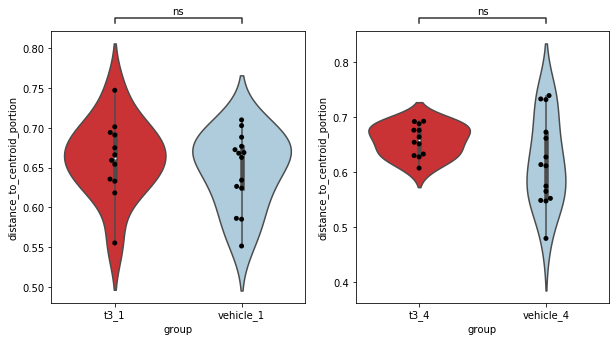

In [7]:
from scipy.stats import kruskal, mannwhitneyu
from statannotations.Annotator import Annotator

fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()

days= ['_1', '_4']
for i in range(len(days)):
    plot_df = mean_df[mean_df.group.str.contains(days[i])].copy()
    t3_array = plot_df[plot_df.group.str.contains('t3')]['distance_to_centroid_portion'].values
    vehicle_array = plot_df[plot_df.group.str.contains('vehicle')]['distance_to_centroid_portion'].values
    sns.violinplot(data=plot_df, x = 'group', y = 'distance_to_centroid_portion', order = sorted(plot_df.group.unique()), ax = axs[i], palette=[sns.color_palette("Paired")[5], sns.color_palette("Paired")[0]])
    sns.swarmplot(data=plot_df, x = 'group', y = 'distance_to_centroid_portion', order = sorted(plot_df.group.unique()),color = 'black', ax = axs[i])
    annotator = Annotator(axs[i], [sorted(plot_df.group.unique())], data=plot_df, x='group', y='distance_to_centroid_portion', order=sorted(plot_df.group.unique()))
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()


## Fig S3E

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_1 vs. vehicle_1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.773e-01 U_stat=7.800e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_4 vs. vehicle_4: Mann-Whitney-Wilcoxon test two-sided, P_val:8.977e-01 U_stat=8.100e+01


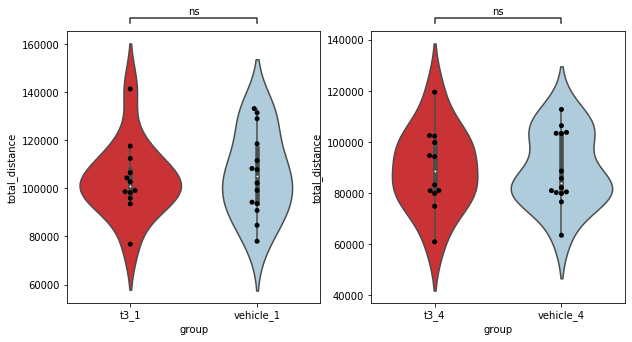

In [8]:
from scipy.stats import kruskal

fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()

days= ['_1', '_4']
for i in range(len(days)):
    plot_df = dist_df[dist_df.group.str.contains(days[i])].copy()
    t3_array = plot_df[plot_df.group.str.contains('t3')]['total_distance'].values
    vehicle_array = plot_df[plot_df.group.str.contains('vehicle')]['total_distance'].values
    sns.violinplot(data=plot_df, x = 'group', y = 'total_distance', order = sorted(plot_df.group.unique()), ax = axs[i], palette=[sns.color_palette("Paired")[5], sns.color_palette("Paired")[0]])
    sns.swarmplot(data=plot_df, x = 'group', y = 'total_distance', order = sorted(plot_df.group.unique()),color = 'black', ax = axs[i])
    annotator = Annotator(axs[i], [sorted(plot_df.group.unique())], data=plot_df, x='group', y='total_distance', order=sorted(plot_df.group.unique()))
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    

## Fig S3 F

In [9]:
master_stats_df = pd.read_csv('./moseq_stats_unfiltered.csv')
master_stats_df = master_stats_df[master_stats_df['syllable'] < max_syll]

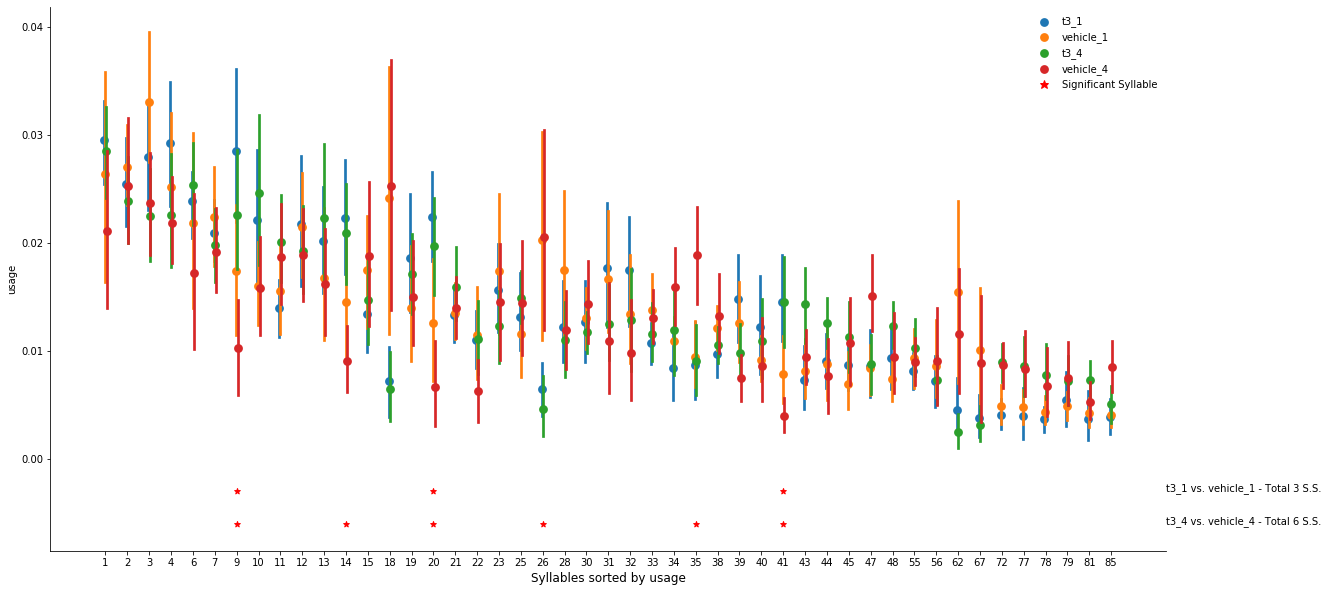

In [10]:
# Syllable Statistics Dependencies
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import ruamel.yaml as yaml
from os.path import exists
from moseq2_viz.util import parse_index
from moseq2_viz.model.stat import run_kruskal
from moseq2_viz.scalars.util import scalars_to_dataframe
from moseq2_viz.model.util import parse_model_results, relabel_by_usage
from moseq2_viz.model.util import (compute_behavioral_statistics, compute_syllable_explained_variance)

import seaborn as sns
import matplotlib.lines as mlines
from moseq2_viz.viz import _validate_and_order_syll_stats_params

def plot_syll_stats_with_sem_mgroup(scalar_df, syll_info=None, sig_sylls=None, stat='usage', ordering='stat', max_sylls=40, keys=[], groups=None, ctrl_group=None, 
                                    exp_group=None, colors=None, join=False,
                                    ci=None, ymin=None, ymax=None, figsize=(10, 5)):

    xlabel = f'Syllables sorted by {stat}'
    if ordering == 'diff':
        xlabel += f' difference ({ctrl_group} vs. {exp_group})'
        
    ordering, groups, colors, figsize = _validate_and_order_syll_stats_params(scalar_df,
                                                                              stat=stat,
                                                                              ordering=ordering,
                                                                              max_sylls=max_sylls,
                                                                              groups=groups,
                                                                              ctrl_group=ctrl_group,
                                                                              exp_group=exp_group,
                                                                              colors=colors,
                                                                              figsize=figsize)
    ordering = sorted(ordering, reverse=False)
    colors=[sns.color_palette("Paired")[5], sns.color_palette("Paired")[0], sns.color_palette("Paired")[4],sns.color_palette("Paired")[1]]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # my_pal = sns.color_palette("Set1")
    # my_pal.reverse()
    # my_pal = my_pal[4:]
    
    # plot each group's stat data separately, computes groupwise SEM, and orders data based on the stat/ordering parameters
    hue = 'group' if groups is not None else None
    ax = sns.pointplot(data=scalar_df, x='syllable', y=stat, hue=hue, order=ordering,
                       join=join, dodge=True, ci=ci, ax=ax, hue_order=groups, colors=colors)

    # where some data has already been plotted to ax
    handles, labels = ax.get_legend_handles_labels()

    # add syllable labels if they exist
    if syll_info is not None:
        mean_xlabels = []
        for o in (ordering):
            mean_xlabels.append(f'{syll_info[o]["label"]} - {o}')

        plt.xticks(range(max_sylls), mean_xlabels, rotation=90)
    
    init_y = -.003
    
    # single group
    sylls_indf = scalar_df.syllable.unique()
    if isinstance(sig_sylls, list):
        markings = []
        for s in sig_sylls:
            markings.append(ordering.index(s))
        plt.scatter(markings, [-.005] * len(markings), color='r', marker='*')

        # manually define a new patch
        patch = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                              markersize=9, label='Significant Syllable')
        handles.append(patch)
    # multi-group
    elif isinstance(sig_sylls, dict):
        for key in keys:
            markings = []
            sig_num = 0
            for s in sig_sylls[key]:
                if s in sylls_indf:
                    markings.append(ordering.index(s))
                    sig_num += 1
            plt.scatter(markings, [init_y] * len(markings), color='r', marker='*')
            plt.text(plt.xlim()[1], init_y, f'{key[0]} vs. {key[1]} - Total {sig_num} S.S.')
            init_y += -.003

        # manually define a new patch
        patch = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                              markersize=9, label='Significant Syllable')
        handles.append(patch)

    # add legend and axis labels
    legend = ax.legend(handles=handles, frameon=False, bbox_to_anchor=(1, 1))
    
    plt.ylim(ymin, ymax) # usages y-axis (single group)
    
    plt.xlabel(xlabel, fontsize=12)
    sns.despine()

    return fig, legend


df_k_real, _, sig = run_kruskal(master_stats_df, max_syllable=92, thresh=0.1)

keys = [('t3_1', 'vehicle_1'),
        ('t3_4', 'vehicle_4'),]
fig, _ = plot_syll_stats_with_sem_mgroup(stats_df, 
                                syll_info=None, # replace with syll_info variable if label dict was loaded
                                sig_sylls=sig,
                                stat='usage', # choose any of the df columns
                                max_sylls=94,
                                groups=['t3_1', 'vehicle_1','t3_4', 'vehicle_4'] ,
                                #groups=[group1, group2], # uncomment this line to only plot 2 groups (ensure to also comment previous groups parameter)
                                ctrl_group=None,
                                exp_group=None,
                                keys=keys,
                                colors=[sns.color_palette("Paired")[5], sns.color_palette("Paired")[0], sns.color_palette("Paired")[4],sns.color_palette("Paired")[1]],
                                join=False,
                                ci=95, # to plot confidence interval error bars, change None to an int between [0, 100]
                                ymin=None, # edit to change minimum plotted y-axis value
                                ymax=None, # edit to change maximum plotted y-axis value
                                figsize=(20,10))


## Fig S3G

In [11]:
import json
trans_mats = np.load('moseq_trans_mats.npy')
with open('moseq_usages_dict.json', 'r') as f:
    usages= json.load(f)

In [12]:
from math import ceil
import networkx as nx


def plot_transition_graph_group_diff(
    groups,
    trans_mats,
    usages,
    syll_include,
    save_dir=None,
    layout="circular",
    node_scaling=100000,
    show_syllable_names=False,
):
    syll_names = [f"{ix}" for ix in syll_include]

    # subsetting transmat
    trans_mats =[tm[syll_include, :][:, syll_include] for tm in trans_mats]
    usages = [[usage[i] for i in syll_include] for usage in usages]

    # take absolute value of usage
    abs_usages = [np.abs(usage) for usage in usages]
    plot_threshold = 0

    n_row = ceil(len(groups) / 2)
    fig, all_axes = plt.subplots(n_row, 2, figsize=(20, 9 * n_row))
    ax = all_axes.flat

    for i in range(len(groups)):
        G = nx.from_numpy_array(trans_mats[i] * 100)
        widths = nx.get_edge_attributes(G, "weight")
        if layout == "circular":
            pos = nx.circular_layout(G)
        else:
            pos = nx.spring_layout(G)
        # get node list
        nodelist = G.nodes()
        # normalize the usage values
        sum_usages = sum(abs_usages[i])
        normalized_usages = np.array([u / sum_usages for u in abs_usages[i]]) * node_scaling + 800
        node_color =[]
        for a in usages[i]:
            if np.abs(a) < plot_threshold:
                node_color.append('white')
            else:
                if a < 0:
                    node_color.append('red')
                else:
                    node_color.append('blue')
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodelist,
            #node_size=normalized_usages,
            node_size=500,
            # node_color=node_color,
            node_color='white',
            edgecolors="black",
            ax=ax[i],
        )
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=widths.keys(),
            width=[np.abs(v/2) for v in widths.values()],
            edge_color=["red" if v < 0 else "blue" for v in widths.values()],
            ax=ax[i],
            alpha=0.6,
        )
        nx.draw_networkx_labels(
            G,
            pos=pos,
            labels=dict(zip(nodelist, syll_names)),
            font_color="black",
            ax=ax[i],
        )
        ax[i].set_title(groups[i])
        print(np.array(list(widths.values())).max())
    # turn off the axis spines
    for sub_ax in ax:
        sub_ax.axis("off")

    return fig

10.876607440855993
11.0745521527602


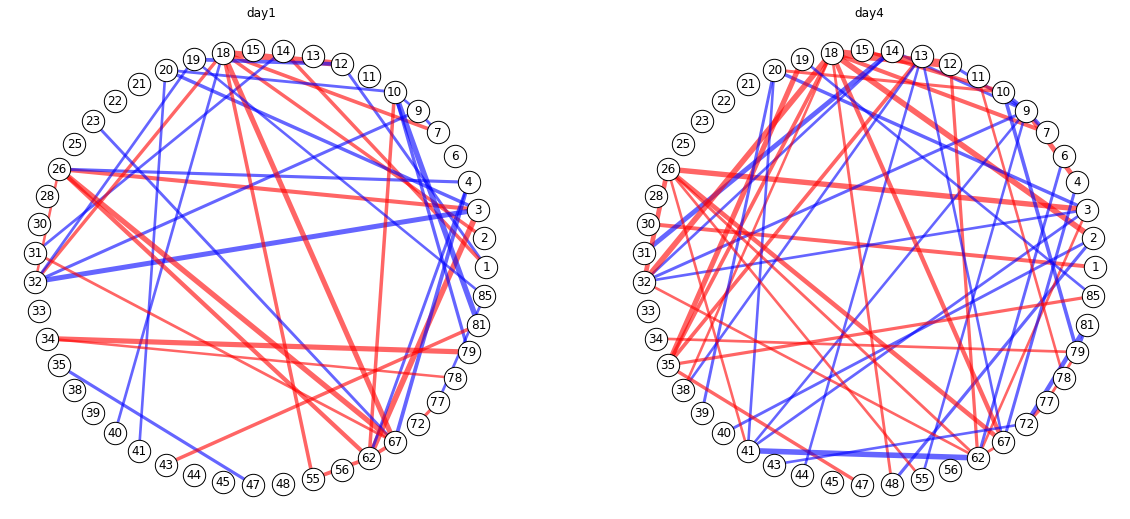

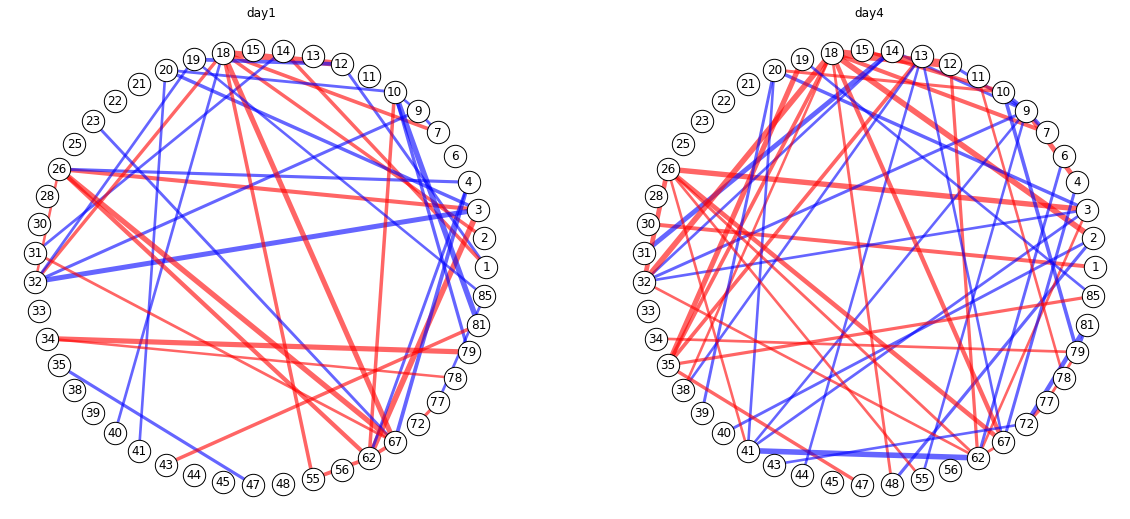

In [13]:
syll_include = stats_df.syllable.unique()
diff_usages = [np.array(list(usages[0].values())) - np.array(list(usages[2].values())), 
               np.array(list(usages[1].values())) - np.array(list(usages[3].values()))]

diff_1 = trans_mats[0] - trans_mats[2]
diff_2 = trans_mats[1] -trans_mats[3]

abs_diff_trans_mats = [np.abs(trans_mats[0] - trans_mats[2]) > 0.05,np.abs(trans_mats[1] -trans_mats[3]) > 0.05]
diff_1[~abs_diff_trans_mats[0]] = 0
diff_2[~abs_diff_trans_mats[1]] = 0
diff_trans_mats = [diff_1, diff_2]

new_group = ['day1', 'day4']
plot_transition_graph_group_diff(
new_group, diff_trans_mats, diff_usages, syll_include,
save_dir=None,
layout="circular",
node_scaling=200,
show_syllable_names=False)

## Fig S3H

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_1 vs. vehicle_1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.786e-02 U_stat=1.200e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_4 vs. vehicle_4: Mann-Whitney-Wilcoxon test two-sided, P_val:9.392e-03 U_stat=1.350e+02


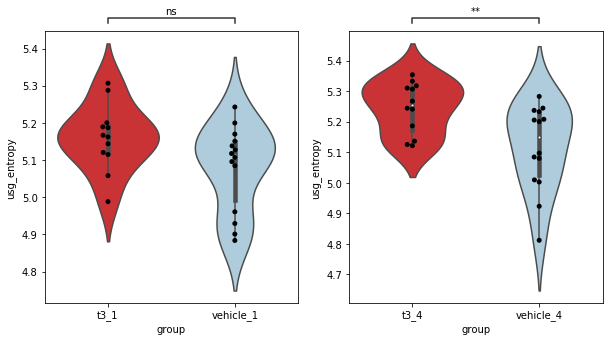

In [14]:
syll_usage = stats_df[['uuid', 'syllable', 'usage', 'group']].pivot_table(index=['uuid','group'], columns='syllable', values='usage').reset_index()
syll_usage.replace(0, 0.00000000001, inplace=True)

usage_distribution = syll_usage.drop(['uuid', 'group'], axis=1).values
usage_distribution = usage_distribution/usage_distribution.sum(axis=1, keepdims=True)
ent_usg = -np.nansum(usage_distribution*np.log2(usage_distribution), axis=1)
syll_usage['usg_entropy'] = ent_usg
usg_entropy_df = syll_usage[['uuid', 'group', 'usg_entropy']]


fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()

days= ['_1', '_4']
for i in range(len(days)):
    plot_df = usg_entropy_df[usg_entropy_df.group.str.contains(days[i])].copy()
    t3_array = plot_df[plot_df.group.str.contains('t3')]['usg_entropy'].values
    vehicle_array = plot_df[plot_df.group.str.contains('vehicle')]['usg_entropy'].values
    sns.violinplot(data=plot_df, x = 'group', y = 'usg_entropy', order = sorted(plot_df.group.unique()), ax = axs[i], palette=[sns.color_palette("Paired")[5], sns.color_palette("Paired")[0]])
    sns.swarmplot(data=plot_df, x = 'group', y = 'usg_entropy', order = sorted(plot_df.group.unique()),color = 'black', ax = axs[i])
    annotator = Annotator(axs[i], [sorted(plot_df.group.unique())], data=plot_df, x='group', y='usg_entropy', order=sorted(plot_df.group.unique()))
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    

## Fig S3I

In [15]:
tm_entropy_df = pd.read_csv('./moseq_tm_entropy.csv')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_1 vs. vehicle_1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.413e-01 U_stat=1.030e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t3_4 vs. vehicle_4: Mann-Whitney-Wilcoxon test two-sided, P_val:3.280e-02 U_stat=1.260e+02


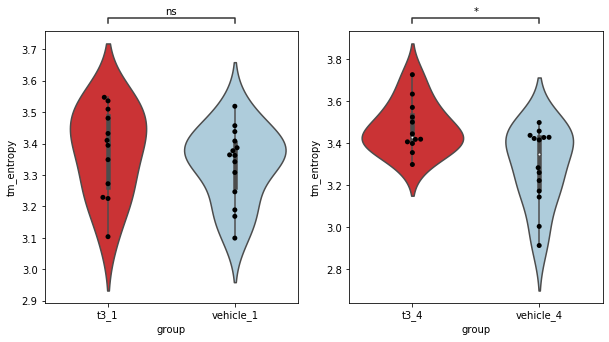

In [16]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()

days= ['_1', '4']
for i in range(len(days)):
    plot_df = tm_entropy_df[tm_entropy_df.group.str.contains(days[i])].copy()
    t3_array = plot_df[plot_df.group.str.contains('t3')]['tm_entropy'].values
    vehicle_array = plot_df[plot_df.group.str.contains('vehicle')]['tm_entropy'].values
    sns.violinplot(data=plot_df, x = 'group', y = 'tm_entropy', order = sorted(plot_df.group.unique()), ax = axs[i],palette=[sns.color_palette("Paired")[5], sns.color_palette("Paired")[0]])
    sns.swarmplot(data=plot_df, x = 'group', y = 'tm_entropy', order = sorted(plot_df.group.unique()),color = 'black', ax = axs[i])
    annotator = Annotator(axs[i], [sorted(plot_df.group.unique())], data=plot_df, x='group', y='tm_entropy', order=sorted(plot_df.group.unique()))
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()